### DATA PREP

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import pandas as pd

train_df = pd.read_csv('/kaggle/input/new-diverse/diverse_train.csv')
test_df = pd.read_csv('/kaggle/input/new-diverse/diverse_test.csv')
val_df = pd.read_csv('/kaggle/input/new-diverse/diverse_val.csv')

train_df = train_df.dropna()
test_df = test_df.dropna()
val_df = val_df.dropna()

In [2]:
WORDS_SIZE=10000

INPUT_SIZE=500

NUM_CLASSES=2

MODEL_NUM=0

EPOCHS=10

In [3]:
x_code = train_df['func'].astype(str)

tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=False)

tokenizer.fit_on_texts(list(x_code))

del(x_code)

print('Number of tokens: ',len(tokenizer.word_counts))

tokenizer.num_words = WORDS_SIZE

# Top 10 words

sorted(tokenizer.word_counts.items(), key=lambda x:x[1], reverse=True)[0:10]


Number of tokens:  279193


[('if', 1140415),
 ('0', 731493),
 ('return', 489853),
 ('1', 423409),
 ('i', 328106),
 ('int', 321264),
 ('s', 299780),
 ('null', 298458),
 ('the', 297447),
 ('t', 279114)]

In [4]:
## Tokkenizing train data and create matrix

list_tokenized_train = tokenizer.texts_to_sequences(train_df['func'].astype(str))

x_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train,

                                  maxlen=INPUT_SIZE,

                                  padding='post')

x_train = x_train.astype(np.int64)

## Tokkenizing test data and create matrix

list_tokenized_test = tokenizer.texts_to_sequences(test_df['func'].astype(str))

x_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test,

                                 maxlen=INPUT_SIZE,

                                 padding='post')

x_test = x_test.astype(np.int64)

## Tokkenizing validate data and create matrix

list_tokenized_validate = tokenizer.texts_to_sequences(val_df['func'].astype(str))

x_validate = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_validate,

                                 maxlen=INPUT_SIZE,

                                 padding='post')

x_validate = x_validate.astype(np.int64)

In [5]:
columns = list(train_df.columns)

columns.remove('target')

columns.extend(['target'])



train_df = train_df[columns]



columns = list(test_df.columns)

columns.remove('target')

columns.extend(['target'])



test_df = test_df[columns]



columns = list(val_df.columns)

columns.remove('target')

columns.extend(['target'])



val_df = val_df[columns]

### ATTENTION BASED CCN MODEL WITH KERAS for predicting CWE-787

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K

EMBEDDING_DIM = 64
WORDS_SIZE = len(tokenizer.word_index) + 1 

random_weights = np.random.normal(size=(WORDS_SIZE, EMBEDDING_DIM), scale=0.01)

x_train = x_train.astype('float32')
y_train = train_df.iloc[:, 2].values.astype('float32')

x_test = x_test.astype('float32')
y_test = test_df.iloc[:, 2].values.astype('float32')

# @keras.saving.register_keras_serializable()
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon()) + 
                      (1-alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

def precision_class1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    class1_pred = y_pred[:, 1]
    class1_true = y_true[:, 1]
    
    true_positives = tf.cast(
        K.sum(K.round(K.clip(class1_true * class1_pred, 0, 1))),
        tf.float32
    )
    predicted_positives = tf.cast(
        K.sum(K.round(K.clip(class1_pred, 0, 1))),
        tf.float32
    )
    
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_class1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    class1_pred = y_pred[:, 1]
    class1_true = y_true[:, 1]

    true_positives = tf.cast(
        K.sum(K.round(K.clip(class1_true * class1_pred, 0, 1))),
        tf.float32
    )
    possible_positives = tf.cast(
        K.sum(K.round(K.clip(class1_true, 0, 1))),
        tf.float32
    )
    
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def build_enhanced_cnn_model(input_size=500):

    code_input = layers.Input(shape=(input_size,), name='code_input')
    
    # Enhanced embedding with larger dimension
    embedding = layers.Embedding(
        input_dim=WORDS_SIZE,
        output_dim=64,
        weights=[random_weights],
        input_length=input_size
    )(code_input)

    # First CNN block with residual connection
    conv1 = layers.Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(embedding)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv1D(filters=256, kernel_size=5, padding='same', activation='relu')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPool1D(pool_size=3)(conv1)
    drop1 = layers.Dropout(0.3)(pool1)

    # Second CNN block with skip connection
    conv2 = layers.Conv1D(filters=512, kernel_size=5, padding='same', activation='relu')(drop1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv1D(filters=512, kernel_size=7, padding='same', activation='relu')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPool1D(pool_size=3)(conv2)
    drop2 = layers.Dropout(0.3)(pool2)

    # Self-attention mechanism
    attention = layers.Dense(1, activation='tanh')(drop2)
    attention = layers.Softmax(axis=1)(attention)
    context = layers.Multiply()([drop2, attention])

    # Global pooling with both max and average pooling
    max_pool = layers.GlobalMaxPooling1D()(context)
    avg_pool = layers.GlobalAveragePooling1D()(context)
    code_features = layers.Concatenate()([max_pool, avg_pool])

    dense1 = layers.Dense(1024, activation='relu')(code_features)
    dense1 = layers.BatchNormalization()(dense1)
    dense1 = layers.Dropout(0.5)(dense1)

    dense2 = layers.Dense(512, activation='relu')(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    dense2 = layers.Dropout(0.3)(dense2)

    dense3 = layers.Dense(128, activation='relu')(dense2)
    dense3 = layers.BatchNormalization()(dense3)
    dense3 = layers.Dropout(0.2)(dense3)

    output = layers.Dense(2, activation='softmax', name='output_1')(dense3)

    model = tf.keras.Model(inputs=[code_input], outputs=output)
    
    return model

# Create and compile model
cnn_model = build_enhanced_cnn_model()

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
# Convert labels and calculate class weights
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weight_dict = dict(enumerate(class_weights))

# Compile with custom optimizer settings
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=True
)

# Compile model
cnn_model.compile(
    optimizer=optimizer,
    loss=focal_loss(gamma=2.0, alpha=0.75),
    metrics=['accuracy', precision_class1, recall_class1]
)


# Training
history = cnn_model.fit(
    [x_train], 
    y_train,
    batch_size=32,
    epochs=15,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_recall_class1',
            patience=10,
            restore_best_weights=True,
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_recall_class1',
            factor=0.5,
            patience=10,
            mode='max',
            min_lr=1e-6
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_cnn_model_np_features.keras',
            monitor='val_recall_class1',
            mode='max',
            save_best_only=True
        )
    ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 179s 29ms/step - accuracy: 0.8181 - loss: 0.0834 - precision_class1: 0.1268 - recall_class1: 0.0838 - val_accuracy: 0.8763 - val_loss: 0.0414 - val_precision_class1: 0.3929 - val_recall_class1: 0.1191 - learning_rate: 0.0010
Epoch 2/15
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 163s 29ms/step - accuracy: 0.8931 - loss: 0.0358 - precision_class1: 0.6801 - recall_class1: 0.4680 - val_accuracy: 0.9014 - val_loss: 0.0314 - val_precision_class1: 0.7179 - val_recall_class1: 0.3254 - learning_rate: 0.0010
Epoch 3/15
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 163s 29ms/step - accuracy: 0.9116 - loss: 0.0285 - precision_class1: 0.7263 - recall_class1: 0.6219 - val_accuracy: 0.9120 - val_loss: 0.0291 - val_precision_class1: 0.7826 - val_recall_class1: 0.4332 - learning_rate: 0.0010
Epoch 4/15
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 160s 28ms/step - accuracy: 0.9278 - loss: 0.0235 - precision_class1: 0.7689 - recall_class1: 0.6971 - val_accuracy: 0.8930 - val_loss: 0.0334 - val_precision

880/880 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


<ipython-input-7-b9b04765b4f0>:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


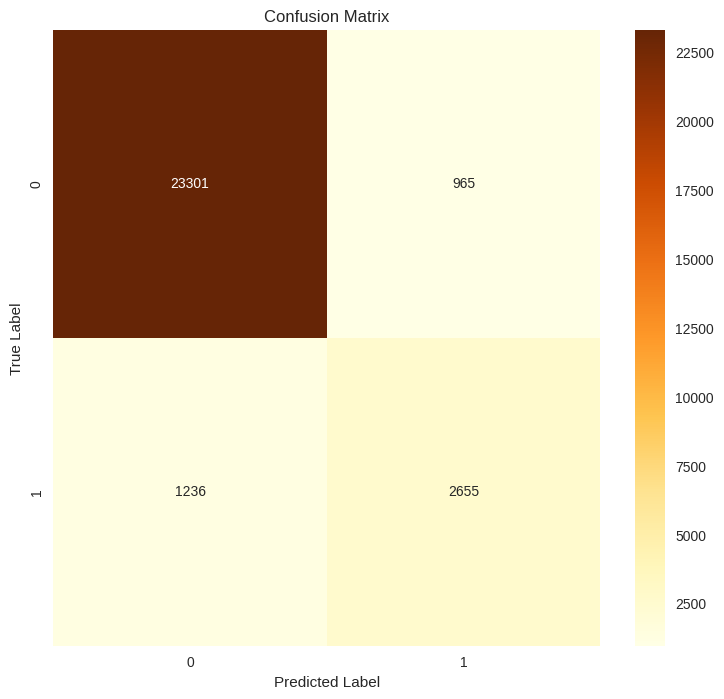

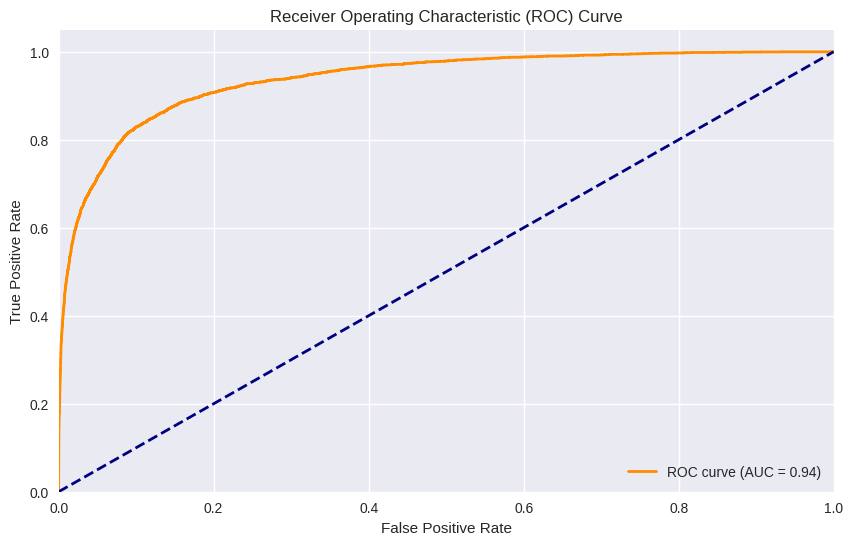

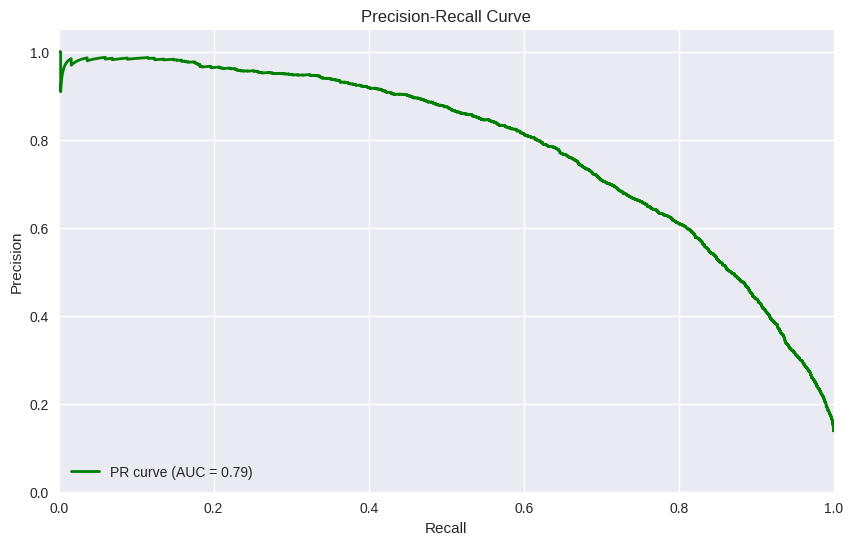


Classification Report:
                precision    recall  f1-score   support

Non-Vulnerable       0.95      0.96      0.95     24266
    Vulnerable       0.73      0.68      0.71      3891

      accuracy                           0.92     28157
     macro avg       0.84      0.82      0.83     28157
  weighted avg       0.92      0.92      0.92     28157


Additional Metrics:
True Negatives: 23301
False Positives: 965
False Negatives: 1236
True Positives: 2655
Precision: 0.7334
Recall: 0.6823
F1 Score: 0.7070
Accuracy: 0.9218
ROC AUC: 0.9373


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# Get predictions
y_pred_proba = cnn_model.predict([x_test])
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# positive_class_probs = y_pred_proba[:, 1]   # Probability of class 1

# In GCN evaluation:
all_labels = y_test_classes                  # Same as y_test_classes
# pred_probs = positive_class_probs            # Same as y_pred_proba[:, 1]

# Create figure with subplots
plt.style.use('seaborn')
fig = plt.figure(figsize=(30, 8))

# 1. Confusion Matrix
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test_classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('cm.png')
plt.show


# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_classes,y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('cnn_roc.png')
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_classes,y_pred_proba[:, 1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig('cnn_precision.png')
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, y_pred, target_names=['Non-Vulnerable', 'Vulnerable']))

# Calculate and print additional metrics
tn, fp, fn, tp = cm.ravel()
print("\nAdditional Metrics:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Precision: {tp/(tp+fp):.4f}")
print(f"Recall: {tp/(tp+fn):.4f}")
print(f"F1 Score: {2*tp/(2*tp+fp+fn):.4f}")
print(f"Accuracy: {(tp+tn)/(tp+tn+fp+fn):.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

### ATTENTION BASED GCN MODEL WITH PYTORCH for predicting CWE-787

In [8]:
!pip install torch torch-geometric networkx

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.8 MB/s eta 0:00:0000:01


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.data import Data, Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import networkx as nx

class EfficientVulnerabilityGCN(nn.Module):
    def __init__(self, num_tokens, embedding_dim=64, hidden_dim=128):
        super(EfficientVulnerabilityGCN, self).__init__()
        
        # Smaller embedding dimension
        self.embedding = nn.Embedding(num_tokens + 1, embedding_dim)
        
        # Fewer layers with smaller dimensions
        self.conv1 = GCNConv(embedding_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        # TopK pooling to reduce graph size
        self.pool1 = TopKPooling(hidden_dim, ratio=0.5)
        
        # Simple output layers
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, 2)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x, edge_index, batch):
        # Embedding
        x = self.embedding(x)
        
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Pooling to reduce graph size
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        # Global pooling
        x = global_mean_pool(x, batch)
        
        # Classification layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

class EfficientCodeDataset(Dataset):
    def __init__(self, x_data, y_data, tokenizer, max_edges=1000):
        self.x_data = x_data
        self.y_data = y_data
        self.tokenizer = tokenizer
        self.max_edges = max_edges
        
    def __len__(self):
        return len(self.x_data)
    
    def create_sparse_graph(self, tokens):
        """Create a sparse graph with limited edges"""
        G = nx.Graph()
        
        # Add nodes
        for i in range(len(tokens)):
            G.add_node(i, token=tokens[i])
        
        # Add sequential edges (guaranteed structure)
        for i in range(len(tokens) - 1):
            G.add_edge(i, i + 1)
        
        # Add a limited number of semantic edges
        edges_added = len(tokens) - 1
        window_size = 3  # Smaller window
        
        for i in range(len(tokens)):
            if edges_added >= self.max_edges:
                break
                
            for j in range(max(0, i-window_size), min(len(tokens), i+window_size+1)):
                if i != j and not G.has_edge(i, j):
                    G.add_edge(i, j)
                    edges_added += 1
                    if edges_added >= self.max_edges:
                        break
        
        return G
    
    def __getitem__(self, idx):
        tokens = self.x_data[idx]
        label = self.y_data[idx]
        
        # Create sparse graph
        G = self.create_sparse_graph(tokens)
        
        edge_index = torch.tensor(list(G.edges())).t().contiguous()
        x = torch.tensor(tokens, dtype=torch.long)
        y = torch.tensor(label, dtype=torch.long)
        
        return Data(x=x, edge_index=edge_index, y=y)

def train_efficient_model(model, train_loader, valid_loader, device, num_epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]).to(device))  # Simple class weighting
    
    best_valid_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Quick validation pass
        model.eval()
        valid_loss = 0
        
        with torch.no_grad():
            for batch in valid_loader:
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = criterion(out, batch.y)
                valid_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {total_loss/len(train_loader):.4f}')
        print(f'Valid Loss: {valid_loss/len(valid_loader):.4f}')
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_efficient_gcn.pt')



In [15]:
y_train = train_df.iloc[:, 2].values.astype('float32')
y_train

array([0., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# y_test = test_df.iloc[:, 2].values

gcn_model = EfficientVulnerabilityGCN(num_tokens=len(tokenizer.word_counts)).to(device)
gcn_model.load_state_dict(torch.load('/kaggle/input/gcn/pytorch/default/1/best_efficient_gcn.pt'))

<ipython-input-20-9335875235bb>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gcn_model.load_state_dict(torch.load('/kaggle/input/gcn/pytorch/default/1/best_efficient_gcn

<All keys matched successfully>

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create datasets with sparse graphs
y_train_torch = torch.tensor(y_train, dtype=torch.long)
train_dataset = EfficientCodeDataset(x_train, y_train_torch, tokenizer)

# Create data loaders with smaller batch size
train_data, valid_data = train_test_split(train_dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=8)

# Initialize model
# model = EfficientVulnerabilityGCN(
#     num_tokens=len(tokenizer.word_counts),
#     embedding_dim=64,  # Smaller embedding
#     hidden_dim=128  # Smaller hidden dimension
# ).to(device)

# Train model
train_efficient_model(gcn_model, train_loader, valid_loader, device)

<ipython-input-19-4b7da1f98b83>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(label, dtype=torch.long)


Epoch 1/10:
Train Loss: 0.3134
Valid Loss: 0.3412
Epoch 2/10:
Train Loss: 0.3007
Valid Loss: 0.3590
Epoch 3/10:
Train Loss: 0.2948
Valid Loss: 0.3115
Epoch 4/10:
Train Loss: 0.2920
Valid Loss: 0.3261
Epoch 5/10:
Train Loss: 0.2873
Valid Loss: 0.3376
Epoch 6/10:
Train Loss: 0.2776
Valid Loss: 0.3290
Epoch 7/10:
Train Loss: 0.2817
Valid Loss: 0.3254
Epoch 8/10:
Train Loss: 0.2771
Valid Loss: 0.3120
Epoch 9/10:
Train Loss: 0.2721
Valid Loss: 0.3201
Epoch 10/10:
Train Loss: 0.2750
Valid Loss: 0.3142


In [22]:
import torch
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    pred_probs = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            outputs = model(batch.x, batch.edge_index, batch.batch)
            probs = torch.exp(outputs)  # Convert log_softmax to probabilities
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
            pred_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1
    

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Non-Vulnerable', 'Vulnerable']))
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, pred_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('gcn_roc.png')
    plt.show()
    
    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(all_labels, pred_probs)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.savefig('gcn_precision.png')
    plt.show()
    
    return pred_probs


<ipython-input-23-c835c17f94f4>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gcn_model.load_state_dict(torch.load('best_efficient_gcn.pt'))


GCN Model Performance:

Classification Report:
                precision    recall  f1-score   support

Non-Vulnerable       0.94      0.95      0.94     24266
    Vulnerable       0.66      0.59      0.62      3891

      accuracy                           0.90     28157
     macro avg       0.80      0.77      0.78     28157
  weighted avg       0.90      0.90      0.90     28157



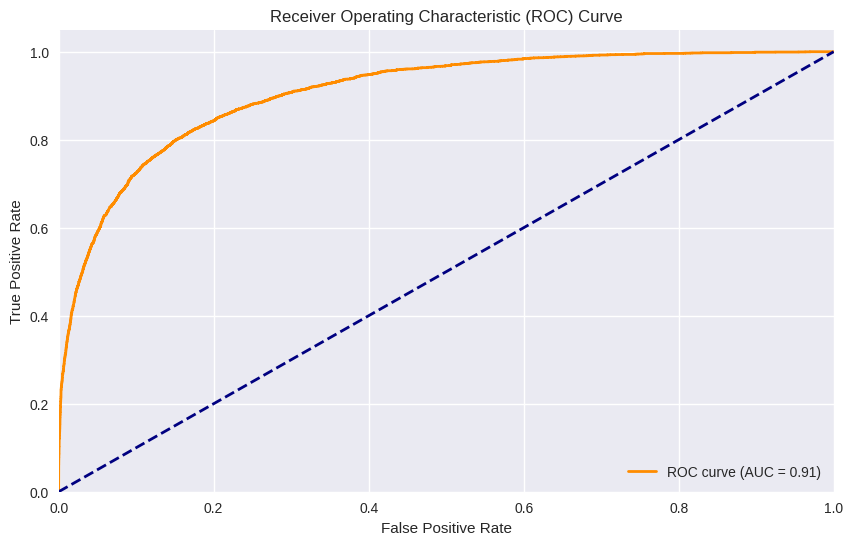

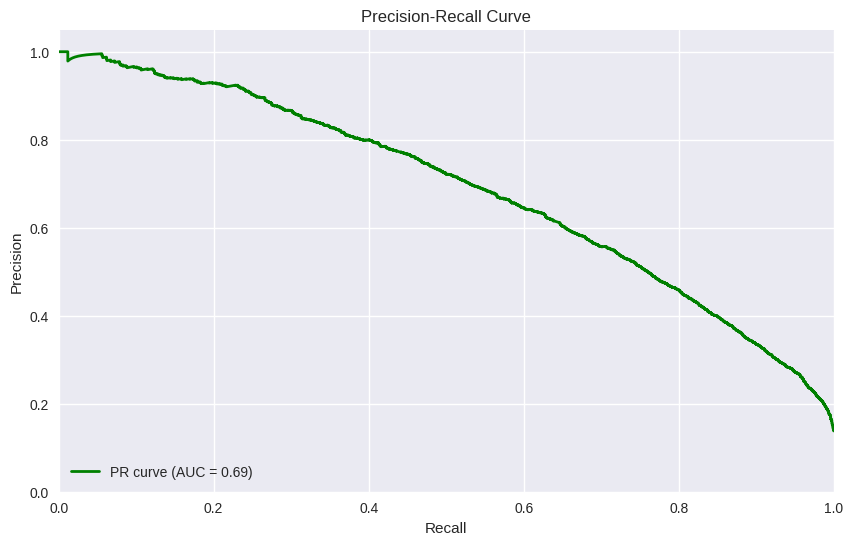

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
y_test = test_df.iloc[:, 2].values

gcn_model = EfficientVulnerabilityGCN(num_tokens=len(tokenizer.word_counts)).to(device)
gcn_model.load_state_dict(torch.load('best_efficient_gcn.pt'))


test_dataset = EfficientCodeDataset(x_test, y_test, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16)


print("GCN Model Performance:")
gcn_probs = evaluate_model(gcn_model, test_loader, device)

<ipython-input-24-d5fe77c88a9c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gcn_model.load_state_dict(torch.load('/kaggle/input/gcn/pytorch/default/1/best_efficient_gcn

GCN Model Performance:

Classification Report:
                precision    recall  f1-score   support

Non-Vulnerable       0.95      0.92      0.94     24266
    Vulnerable       0.59      0.67      0.63      3891

      accuracy                           0.89     28157
     macro avg       0.77      0.80      0.78     28157
  weighted avg       0.90      0.89      0.89     28157



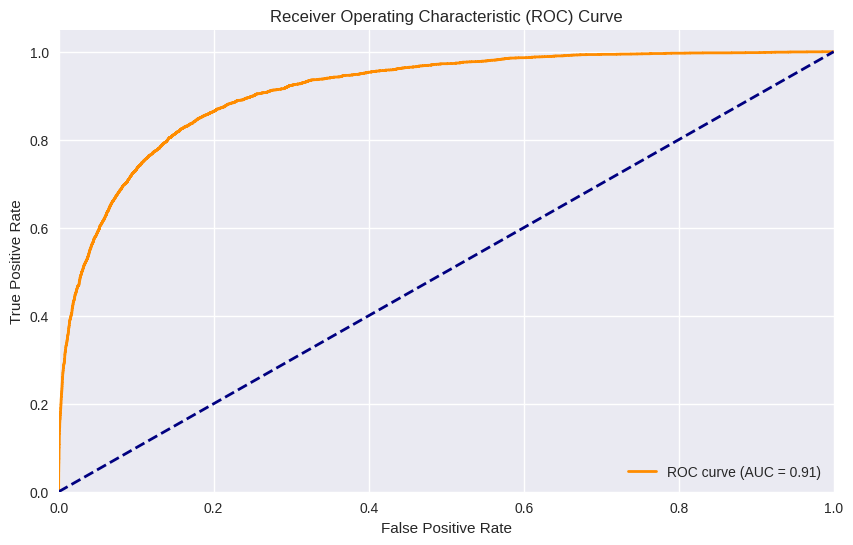

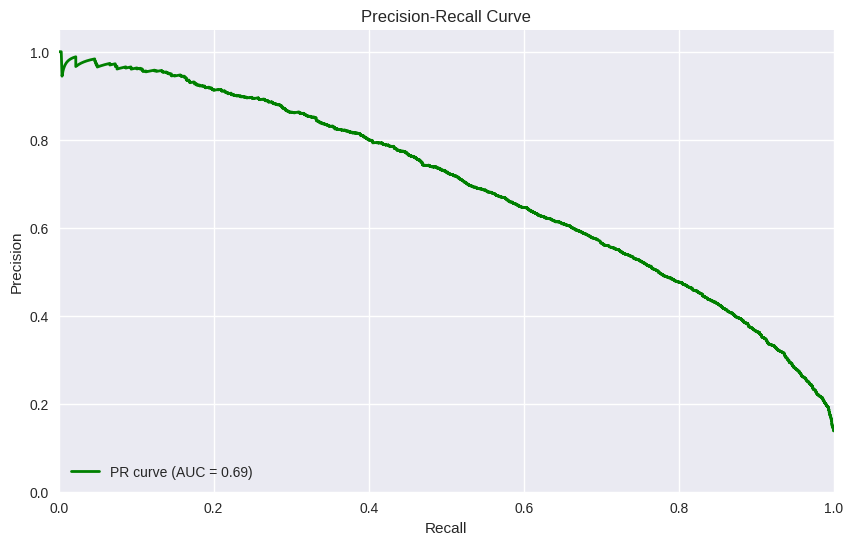

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
y_test = test_df.iloc[:, 2].values

gcn_model = EfficientVulnerabilityGCN(num_tokens=len(tokenizer.word_counts)).to(device)
gcn_model.load_state_dict(torch.load('/kaggle/input/gcn/pytorch/default/1/best_efficient_gcn.pt'))


test_dataset = EfficientCodeDataset(x_test, y_test, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16)


print("GCN Model Performance:")
gcn_probs = evaluate_model(gcn_model, test_loader, device)

### ENSEMBLE

In [25]:
    
class VulnerabilityEnsemble:
    def __init__(self, gcn_model, cnn_model, device):
        self.gcn_model = gcn_model
        self.cnn_model = cnn_model
        self.device = device
        self.meta_classifier = LogisticRegression(C=1.0, class_weight='balanced')
        
    def get_gcn_predictions(self, test_loader):
        self.gcn_model.eval()
        gcn_probs = []
        
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(self.device)
                outputs = self.gcn_model(batch.x, batch.edge_index, batch.batch)
                probs = torch.exp(outputs)
                # Only take the probability for positive class
                gcn_probs.extend(probs[:, 1].cpu().numpy())
        
        return np.array(gcn_probs)
    
    def get_cnn_predictions(self, x_test):
        # Only return probabilities for positive class
        # cnn_model.predict([x_test])
        return self.cnn_model.predict([x_test])[:, 1]
    
    def train_meta_classifier(self, train_gcn_loader, x_train_cnn, y_train):
        # Get predictions from both models
        gcn_train_preds = self.get_gcn_predictions(train_gcn_loader)
        cnn_train_preds = self.get_cnn_predictions(x_train_cnn)
        
        # Combine predictions
        meta_features = np.column_stack([gcn_train_preds, cnn_train_preds])
        
        # Ensure y_train is 1D
        if len(y_train.shape) > 1:
            if y_train.shape[1] == 2:
                # If y_train is one-hot encoded, convert to 1D
                y_train = y_train[:, 1]
            else:
                y_train = y_train.ravel()
                
        # Train meta-classifier
        self.meta_classifier.fit(meta_features, y_train)
    
    def predict(self, test_gcn_loader, x_test_cnn):
        # Get predictions from both models
        gcn_test_preds = self.get_gcn_predictions(test_gcn_loader)
        cnn_test_preds = self.get_cnn_predictions(x_test_cnn)
        
        # Combine predictions
        meta_features = np.column_stack([gcn_test_preds, cnn_test_preds])
        
        # Get ensemble predictions
        ensemble_preds = self.meta_classifier.predict_proba(meta_features)[:, 1]
        return ensemble_preds

In [26]:
ensemble = VulnerabilityEnsemble(gcn_model, cnn_model, device)


train_dataset = EfficientCodeDataset(x_train, y_train_torch, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16)


ensemble.train_meta_classifier(train_loader, x_train, y_train)



/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
<ipython-input-19-4b7da1f98b83>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(label, dtype=torch.long)


7127/7127 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step


In [29]:
ensemble_probs

array([0.01172153, 0.03784708, 0.0090077 , ..., 0.06892461, 0.1160589 ,
       0.00983697])

In [30]:
# ensemble_probs = ensemble.predict(test_loader, x_test)

print("\nEnsemble Model Performance:")
print(classification_report(y_test, (ensemble_probs > 0.5).astype(int)))




Ensemble Model Performance:
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     24266
         1.0       0.64      0.80      0.71      3891

    accuracy                           0.91     28157
   macro avg       0.80      0.86      0.83     28157
weighted avg       0.92      0.91      0.91     28157



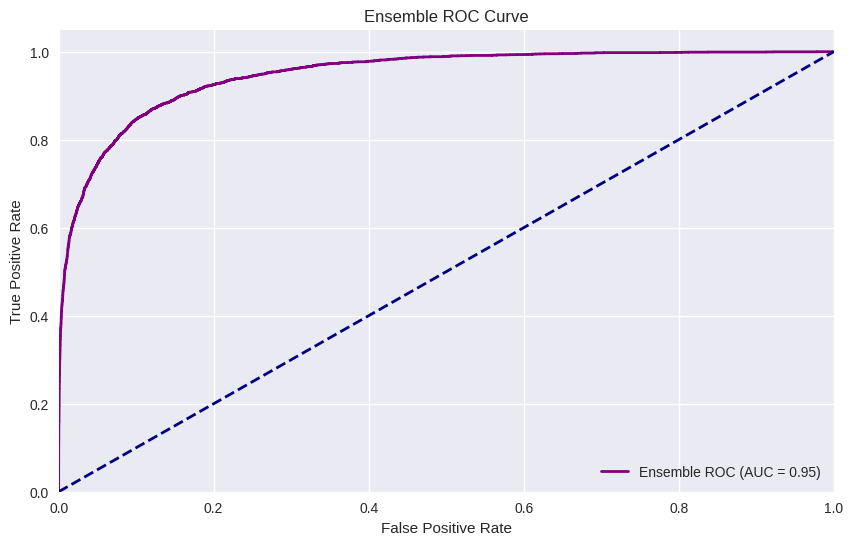

In [33]:
# Plot ROC curve for ensemble
fpr, tpr, _ = roc_curve(y_test, ensemble_probs)
ensemble_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'Ensemble ROC (AUC = {ensemble_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('ensemble.png')
plt.show()